In [8]:
import gzip
import json
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import heapq
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_gender = []
with gzip.open("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/librarything_author_gender.json.gz") as fin:
    for l in fin:
        #print(l)
        d = json.loads(l)
        if d['author_gender'] != 'n/a':
            df_gender.append([d['author_name'], d['author_gender']])
df_gender = pd.DataFrame(df_gender, columns=['name', 'gender']).drop_duplicates()
df_gender.head()

,name,gender
0,Arthur Millier,male
1,Helen Little,female
2,Michael Moskowitz,male
3,Katherine Schober,female
4,Yingcong Dai,female


In [66]:
df_author = []
with gzip.open(os.path.join("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/", 'goodreads_books_matched_poetry.json.gz')) as fin:
    for l in fin:
        
        d = json.loads(l)
        df_author.append([d['book_id'],d['title'],[i['author_id'] for i in d['authors']], [j['gender'] for j in d['authors']]])
df_author = pd.DataFrame(df_author, columns=['book_id','title','author_id', 'author_gender'])
single_authors_only = df_author[df_author['author_id'].str.len() ==1]
single_authors_only['author_id'] = single_authors_only['author_id'].map(lambda x: x[0])
single_authors_only['author_gender'] = single_authors_only['author_gender'].map(lambda x: x[0])
single_authors_only.drop( single_authors_only['author_gender']  == 'None', inplace=True)
single_authors_only.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

,book_id,title,author_id,author_gender
3,15861988,Into Temptation,2988946,female
4,9495428,Dark Sons,25492,female
5,554372,Geografías,30195,male
6,20544060,Black Liquor: Poems,547708,male
8,2067880,Cornflakes: Poems,68669,male


In [11]:
poetry_reviews = []
user_to_book = {}
book_to_user = {}
with gzip.open(os.path.join("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/", 'goodreads_reviews_matched_poetry_en.json.gz')) as fin:
    for l in fin:
        d = json.loads(l)
        user = d['user_id']
        book = d['book_id']
        poetry_reviews.append([user,book, d['review_id'], d['rating']])
        
poetry_reviews = pd.DataFrame(poetry_reviews, columns=['user_id','book_id','review_id', 'rating'])
gb = poetry_reviews.groupby("user_id").filter(lambda x: len(x) >= 5)
user_author = gb.merge(single_authors_only, on='book_id', how='left').dropna()

In [12]:
user_to_book = {}
book_to_user = {}
book_to_title = {}
book_to_title = {}
for index, row in user_author.iterrows():
    user, book, title =row['user_id'], row['book_id'], row['title']
    if user in user_to_book.keys():
        user_to_book[user].add(book)
    else:
        user_to_book[user] = set()
        user_to_book[user].add(book)
            
    if book in book_to_user.keys():
        book_to_user[book].add(user)
    else:
        book_to_user[book] = set()
        book_to_user[book].add(user)
        
    if book in book_to_title.keys():
        book_to_title[book].add(title)
    else:
        book_to_title[book] = set()
        book_to_title[book].add(title)

In [13]:
# item-item similarity
def jaccard(book_A, book_B):
    union_count = 0
    total_count = 0
    #get all users who bought book A
    A_users = book_to_user[book_A]
    B_users = book_to_user[book_B]
    i = len(A_users.intersection(B_users))
    j = len(A_users) + len(B_users) - i
    return i/j

    
# def intersection(lst1, lst2): 
#     lst3 = [value for value in lst1 if value in lst2] 
#     return lst3


In [14]:
def i_i_recommendation(user, prnt):
    max_similarity = 0.0
    other_items = set(user_author['book_id'].tolist()) #ALL ITEMS
    this_user_items = user_author[user_author['user_id']== user]['book_id'].tolist()
    if prnt:
        print("This users purchased items are: ")
    for item in this_user_items:
        if prnt:
            print(item)
        if item in other_items:
            other_items.remove(item)
            
    for rec_item in other_items:
        #print("Non-purchased item")
        #print(rec_item)
        for bought_item in this_user_items:
         #   print("Purchased item")
         #   print(bought_item)
            if jaccard(rec_item, bought_item) > max_similarity:
                reccomendation = rec_item
                max_similarity = jaccard(rec_item, bought_item)

    
    #name = user_author['book_id' == reccomendation]['title'].idxmax() #idxmax gets first occurance in a df
    return reccomendation, max_similarity

In [15]:
i_i_recommendation('d1e368a7d2870eb6fbf6e0d350568a2d', False)

('17346812', 0.25)

In [16]:
user_author[user_author['book_id'] == '640133']['title']

15944    Spring: A Haiku Story
Name: title, dtype: object

In [17]:
def n_item_recommendations(user, n):
    best_recs = list()
    this_user_books = user_to_book[user]
#     other_items = set(book_to_title.keys()) #ALL ITEMS
#     this_user_items = user_to_book[user]
#  #   print("This users purchased items are: ")
#     for item in this_user_items:
#   #      print(item)
#         if item in other_items:
#             other_items.remove(item)
    
#instead of looking at all other items, only look at those which were bought by a user who shares at least 1 iten
    other_items = set()
    for u in user_to_book.keys():
        if set(user_to_book[u]).intersection(this_user_books) != 0:
            other_items.update(user_to_book[u])
   # print("finished constructing other_items list")
    heapq.heapify(best_recs)
    for rec_item in other_items:
        for bought_item in this_user_books:
            similarity = jaccard(rec_item, bought_item)
            if len(best_recs) < n:
                heapq.heappush(best_recs, (similarity, rec_item))
            else:
                smallest = heapq.heappop(best_recs)
                if smallest[0] >= similarity:
                    heapq.heappush(best_recs, smallest)
                else:
                    heapq.heappush(best_recs, (similarity, rec_item))

    return [x[1] for x in best_recs]

In [18]:
n_item_recommendations('d1e368a7d2870eb6fbf6e0d350568a2d', 3)

['14950010', '397743', '17243953']

In [19]:
main = user_author.groupby("user_id").filter(lambda x: len(x) >= 5)
main

,user_id,book_id,review_id,rating,title,author_id,author_gender
14,f1be68e7aec2297644ee1fefe40b933d,1054593,df6f127e50e71483906bb762df0c04be,5,The Kingdom of Ordinary Time: Poems,15804,female
15,f1be68e7aec2297644ee1fefe40b933d,593236,f9faad0bb3271d750a90d2ead1bd2ef6,4,Runny Babbit: A Billy Sook,435477,male
18,f1be68e7aec2297644ee1fefe40b933d,102331,cf24fb68616aa07192c96470051ae9c3,2,A Night Without Armor,59064,female
19,f1be68e7aec2297644ee1fefe40b933d,104090,a6a2ba809fdc31edcde5ffd58aaa0eaa,3,Beyond This Dark House,60177,male
20,f1be68e7aec2297644ee1fefe40b933d,699676,18d50aa32c756d62010b476111311a4d,5,Smoke from This Altar,858,male
23,bb1d3f753d7409a421dc6629eded2d8c,2259243,499a72eb20aa96465c66fecb78df6792,2,Hot Teen Slut,492712,female
24,bb1d3f753d7409a421dc6629eded2d8c,676,df882ff7474705799a1a5d040b156f66,2,Sailing Alone Around the Room: New and Selecte...,438,male
25,bb1d3f753d7409a421dc6629eded2d8c,5974575,ff600bed149f4d644fee12b44d76cf83,1,The Best of It: New and Selected Poems,74815,female
26,bb1d3f753d7409a421dc6629eded2d8c,6772144,0fd0eb068be73bbf991db563ea01a721,4,The Last Time as We Are,73439,male
27,bb1d3f753d7409a421dc6629eded2d8c,117336,8016482732aa9db11e75428cf8856629,5,The Pill vs. the Springhill Mine Disaster,7970,male


In [122]:
'd1e368a7d2870eb6fbf6e0d350568a2d'

'd1e368a7d2870eb6fbf6e0d350568a2d'

In [173]:
def user_based_knn(user, num_recs):

    this_user_purchases = user_to_book[user]
    #all_recs = set()

    ru = rank_users(user)
#     while len(all_recs) != num_recs:
#         books = heapq._heappop_max(ru)[1] # set of books this correlated user has purchased
#         for book in books:
#             if len(all_recs) < num_recs and book not in this_user_purchases:
#                 all_recs.add(book)
    
    #take top 5 most similar users and do a weighted sum
    weighted_sum = dict()
    books_and_similarity = list()
   # print("Length of ranked user list: " + str(len(ru)))
    while len(ru) > 0:
        #pop from maxheap
        sim, books = heapq._heappop_max(ru)
       # print(books)
        for book in books:
            if book not in this_user_purchases and sim !=0:
                if book in weighted_sum.keys():
                    weighted_sum[book] += sim
                else:
                    weighted_sum[book] = sim
    rec_list =  heapq.nlargest(num_recs, weighted_sum.keys())
    if len(rec_list) == 0:
        #if they have nothing in common with other users simply return the 50 most popular books
        most_popular_books = dict()
        for book in book_to_user.keys():
            most_popular_books[book] = len(book_to_user[book])
        return heapq.nlargest(num_recs, most_popular_books.keys())
    else:
        return rec_list

    

In [174]:
def rank_users(user):
    ranked_users = list()
    heapq._heapify_max(ranked_users)
    #print(user_to_book.keys())
    other_users = set(user_to_book.keys())

    #construct a heap from the set of users
    for o in other_users:
        if o != user:
            similarity = user_jaccard(user, o)
            #print("Similarity: " + str(similarity))
            heapq.heappush(ranked_users, (similarity, user_to_book[o]))
    #construct a set of recommended items
   # print("Ranked User List: ")
   # print(rank_users)
    return ranked_users

In [180]:
def user_jaccard(user_A, user_B):
    #get all users who bought book A
    A_Books = user_to_book[user_A]
    B_Books = user_to_book[user_B]
    i = len(A_Books.intersection(B_Books))
    j = len(A_Books) + len(B_Books) - i
    true_similarity = i/j
    
    if i < 50:
        weight = i/50
        #print("similarity is: " + str(true_similarity * weight))
        return true_similarity * weight
    else:
        #print("similarity is: " + str(true_similarity))
        return true_similarity 

# Procedure from Author Bias paper:
1. Import data (done above)
2. Sample 1000 users who have over 5 reviews
3. Calculate gender distribution in the sample
4. Produce 50 recomendations for each user, using the entire dataset
5. Compute recomendation gender distribution, compare with sample gender distribution

In [51]:
srs = main.drop_duplicates('user_id')['user_id'].sample(n=1000,random_state=24 )
srs.count()

1000

overall proportion:  0.44888514934791757


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


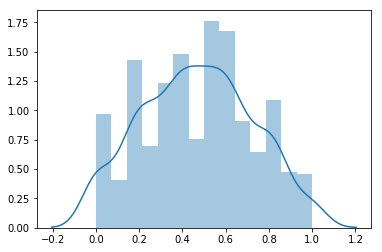

In [52]:
user_ratio = {}
proportions = []
running_total_females = 0
running_overall_total = 0
users= set(srs)
for u in users:
    total_reviews = main[(main['user_id'] == u)]['user_id'].count()
    num_females = main[(main['user_id'] == u) & (main['author_gender']=='female')]['user_id'].count()
    ratio = num_females/total_reviews
    running_total_females += num_females
    running_overall_total += total_reviews
    user_ratio[u] = ratio
    proportions.append(ratio)
print("overall proportion: ", str(running_total_females/running_overall_total))
sns_plot = sns.distplot(proportions, kde=True, rug=False);
fig = sns_plot.get_figure()
fig.savefig("user_proportion_female_reviews.png")
plt.show()

In [53]:
i = pd.DataFrame(data = {'proportion': proportions}) 
i.describe()

,proportion
count,1000.000000
mean,0.467728
std,0.255090
min,0.000000
25%,0.283730
50%,0.500000
75%,0.652924
max,1.000000


In [141]:
n = 50 
user_to_recs = {}
for u in users:
    user_to_recs[u] = n_item_recommendations(u, n)

In [142]:
rec_ratio = {}
proportions = []
running_total_females = 0
running_overall_total = 0
users= set(user_to_recs.keys())


for u in users:
    recs = user_to_recs[u]
    #print(recs)
    total_reviews = len(recs)
    num_females = len(single_authors_only[(single_authors_only['book_id'].isin(recs)) & (single_authors_only['author_gender'] =='female')]['book_id'].unique())
    
    ratio = num_females/total_reviews
    running_total_females += num_females
    running_overall_total += total_reviews
    rec_ratio[u] = ratio
    proportions.append(ratio)
print("overall proportion: ", str(running_total_females/running_overall_total))


overall proportion:  0.30614


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


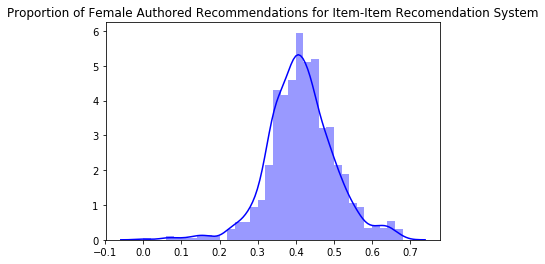

In [184]:
sns_plot = sns.distplot(proportions, kde=True, color='b', rug=False).set_title("Proportion of Female Authored Recommendations for Item-Item Recomendation System")
fig = sns_plot.get_figure()
fig.savefig("Item_Item_rec_proportion.png")
plt.show()

In [144]:
i = pd.DataFrame(data = {'proportion': proportions}) 
i.describe()

,proportion
count,1000.000000
mean,0.306140
std,0.152702
min,0.000000
25%,0.180000
50%,0.320000
75%,0.420000
max,0.700000


In [179]:
user_based_knn('d92f95b95d015036cecf4b7ba92ff8ad', 50)
user_to_book['d92f95b95d015036cecf4b7ba92ff8ad']

{'16119929', '16435276', '19000183', '329522', '563809'}

In [181]:
n = 50 
users= set(srs)
user_to_u_based_recs = {}
for u in users:
    user_to_u_based_recs[u] = user_based_knn(u, n)


In [182]:
rec_ratio = {}
proportions = []
running_total_females = 0
running_overall_total = 0
users = user_to_u_based_recs.keys()
for u in users:
    recs = user_to_u_based_recs[u]
    print(u)
    print(recs)
    print(len(recs))
    total_reviews = len(recs)
    num_females = len(single_authors_only[(single_authors_only['book_id'].isin(recs)) & (single_authors_only['author_gender'] =='female')]['book_id'].unique()) 
    ratio = num_females/total_reviews
    running_total_females += num_females
    running_overall_total += total_reviews
    rec_ratio[u] = ratio
    proportions.append(ratio)
print("overall proportion: ", str(running_total_females/running_overall_total))

f8c32fbcddf11932bb13ec95827d0b57
['9992486', '9987466', '998168', '9981436', '99713', '996521', '9964335', '99569', '9954531', '9947556', '99437', '99436', '99435', '99375', '993140', '9930356', '99277', '9913131', '9905592', '989449', '9894268', '989201', '98712', '9870010', '985607', '9851926', '9843527', '9841743', '9837625', '9828871', '9826062', '981907', '981528', '9814909', '9811933', '981126', '981125', '981024', '979277', '979036', '978917', '9775230', '9762904', '976072', '975994', '97553', '97461', '97458', '974563', '97409']
50
1415230efe42653327ce9b9b6b23005c
['99713', '99569', '99437', '99435', '99428', '993140', '9930356', '991745', '991734', '989201', '98712', '9870010', '982469', '981812', '981125', '981024', '979036', '975942', '97553', '97409', '9736411', '973197', '971082', '970573', '969620', '9672012', '966972', '9654817', '964598', '964142', '9639765', '9627996', '96259', '9605240', '95857', '9583799', '9567170', '956428', '955268', '955264', '953814', '953813', 

50
f0e2d779769bc13eb7288e9de291309b
['9990667', '998383', '9981436', '99713', '9964335', '9962651', '99569', '9954531', '9947556', '99437', '99436', '99435', '99375', '993140', '9930356', '9913131', '989960', '989201', '98712', '9870010', '985607', '9851926', '9851811', '984881', '984851', '984838', '9828871', '9826976', '981812', '981528', '9811933', '981127', '981126', '981125', '981024', '980966', '979277', '979170', '979130', '979036', '978917', '977558', '977557', '977171', '976072', '975994', '97553', '974563', '9743885', '97409']
50
0f6a6aa3ee8e5296d843bed2d66f498d
['9981436', '99713', '99437', '99435', '99428', '9930356', '991745', '991734', '989201', '98712', '985607', '981812', '981125', '981024', '979277', '979036', '97553', '974563', '97409', '971082', '969620', '966972', '9654817', '964598', '964142', '9639765', '9627996', '96259', '9605240', '9583799', '958093', '955268', '955264', '953814', '953813', '9494844', '946850', '9444', '9413933', '939267', '93598', '934756', '9

['708035', '67599', '6624241', '3066657', '30075802', '23473202', '20702539', '194533', '17287056', '145108', '1404593', '127684']
12
e8439ed220c164f82f4cb5489bd548c8
['9992486', '99436', '99375', '986895', '9811933', '9775230', '9762904', '974563', '966193', '9655', '964142', '9639765', '96259', '96050', '9583799', '9471417', '947131', '93598', '933880', '9315496', '92604', '9028798', '891268', '8862556', '880798', '8800781', '879989', '8771372', '874800', '8747308', '857349', '8492877', '848297', '83972', '835249', '833395', '8303201', '820442', '8122927', '807698', '802446', '799568', '798108', '7961474', '7960189', '7844710', '777171', '775399', '768496', '765172']
50
01b4f28fa3501fc7fafb18ab36bd91c9
['9987466', '9981436', '99713', '996927', '99569', '9954531', '9947556', '99436', '99435', '9941367', '99375', '993140', '9930356', '9913131', '9908555', '9870010', '985607', '9851811', '984838', '9828871', '9826976', '9826062', '981528', '9814909', '9811933', '981126', '981125', '9810

f69b5cc0e3436ebd9311825d19d936fa
['9992486', '998168', '99713', '996521', '9964335', '99437', '99436', '99375', '993140', '989449', '9870010', '9851926', '981528', '9811933', '979036', '9775230', '9762904', '976072', '975994', '97553', '974563', '97409', '966193', '9658', '9655', '964142', '9639765', '963911', '963711', '96259', '9599405', '959410', '9583799', '956428', '9545171', '9502973', '947131', '9444', '9413933', '9397035', '936843', '93598', '93491', '933880', '932753', '9315496', '9303080', '9258089', '925765', '922651']
50
78c3bb7f96f6e8ca78f9aa3a63ce0ed8
['9992486', '998168', '99713', '996521', '9964335', '99437', '99436', '99375', '993140', '989449', '9870010', '9851926', '981812', '981528', '9811933', '979036', '9775230', '9762904', '976072', '975994', '97553', '974563', '97409', '9658', '9655', '964142', '9639765', '963911', '963711', '96259', '96050', '9599405', '9583799', '956428', '9545171', '9502973', '947131', '9444', '9413933', '9397035', '936843', '93598', '93491',

['9992486', '9990667', '998168', '99375', '9913131', '986661', '985607', '984838', '981907', '9775230', '9762904', '974563', '9743885', '97409', '965354', '964142', '9639765', '963711', '9605240', '96050', '95874', '9583799', '956139', '9367454', '933880', '932753', '9315496', '9266808', '9258089', '9127008', '90823', '90597', '905345', '902792', '902791', '9003078', '892791', '8901945', '884234', '881566', '880798', '8780497', '874800', '8747308', '871022', '867678', '854651', '8522640', '850867', '8504102']
50
e27849a4483951ae75f4676f5ad54dd1
['998383', '99713', '9962651', '99436', '99435', '99428', '993140', '9908555', '989980', '98940', '98712', '986895', '9851926', '9826976', '9808957', '977558', '977557', '97553', '97409', '973072', '973069', '972093', '9712033', '971082', '9685272', '9670742', '966972', '965354', '9639765', '96259', '9595881', '9583799', '9571046', '956365', '956139', '955276', '955275', '955267', '955264', '9545171', '953813', '9502973', '947746', '947131', '94

f9a532e86fc3606e9590d41a4a5ebef9
['9992486', '9987466', '998168', '9981436', '99713', '9964335', '99569', '9954531', '9947556', '99437', '99436', '99375', '993140', '9930356', '9913131', '989449', '9870010', '985607', '9828871', '9826062', '981528', '9814909', '9811933', '981126', '981125', '981024', '979277', '979036', '978917', '9775230', '9762904', '976072', '975994', '97553', '974563', '97409', '9736411', '973068', '9722329', '9707758', '969620', '9689681', '966956', '9666846', '9658', '9655', '9654817', '964665', '964598', '964142']
50
efc530d371af803ce1e311ff8ccac165
['9981436', '9976138', '99713', '9947556', '99436', '9913131', '989960', '98940', '9851926', '9851811', '9826976', '9811933', '979279', '979130', '978917', '977558', '977557', '97553', '97409', '973072', '973068', '972093', '9712033', '971103', '971082', '9708234', '9689681', '9685272', '9678', '9670742', '966972', '9666846', '96648', '9662108', '9654817', '964047', '9639765', '96259', '9605240', '96052', '9595881', 

9915f0c43b566eef036e8e25d2ea185c
['9992486', '9968461', '99436', '993140', '9930356', '989960', '9875696', '9870010', '981528', '9811933', '981126', '981125', '97684', '97553', '9736411', '968258', '9670662', '9670245', '9654817', '9639765', '96259', '95874', '95845', '95844', '9583799', '952901', '945817', '9413933', '934690', '9315496', '930738', '929582', '9258089', '9167624', '9083248', '902792', '902746', '8747308', '8703751', '865700', '864051', '863932', '853926', '8529291', '852777', '8504102', '848295', '8462385', '8461909', '8431208']
50
95b22f99934e50fa545d40099e3986e2
['9992486', '998168', '99713', '99437', '99436', '99435', '99428', '99375', '993140', '9930356', '989980', '989744', '989449', '98940', '986895', '986038', '982469', '981528', '981126', '981125', '979036', '9775230', '97684', '9762904', '976072', '97553', '9754454', '974563', '97409', '973197', '966972', '966193', '9658', '9655', '9654817', '9654465', '9639765', '963029', '96259', '962129', '96050', '9598618',

50
ffd6c966d94d3d06c8cc4480536082b4
['9992486', '998383', '998168', '9981436', '99713', '996521', '9964335', '9947556', '99436', '99435', '99428', '99375', '993140', '9930356', '9913131', '989980', '989967', '989449', '989201', '9870010', '9851926', '984838', '9838168', '9837625', '9828871', '9811933', '979036', '978917', '9775230', '9762904', '976072', '97553', '974563', '97409', '9736411', '9670742', '966972', '9658', '9655', '9654817', '965354', '964142', '9639765', '963911', '963711', '9627996', '96259', '9605240', '96051', '958900']
50
1cff79dace43248135560b41e4466904
['9987466', '9981436', '99713', '996927', '99569', '9954531', '9947556', '99436', '99435', '99375', '993140', '9930356', '9913131', '9908555', '989449', '9870010', '986895', '985607', '9851811', '984838', '9838168', '9837625', '9828871', '9826976', '9826062', '981528', '9814909', '9811933', '981126', '981125', '981024', '980556', '979277', '979036', '978917', '977558', '977557', '977171', '97684', '976072', '97553', 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


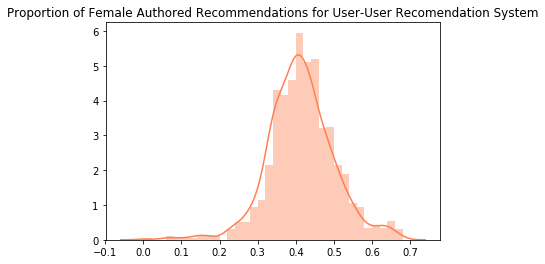

,proportion
count,1000.000000
mean,0.412456
std,0.087017
min,0.000000
25%,0.360000
50%,0.400000
75%,0.460000
max,0.680000


In [183]:
sns_plot = sns.distplot(proportions, kde=True, color='coral', rug=False).set_title("Proportion of Female Authored Recommendations for User-User Recomendation System")
fig = sns_plot.get_figure()
fig.savefig("User_User_rec_proportion_weight_in_jaccard.png")
plt.show()
i = pd.DataFrame(data = {'proportion': proportions}) 
i.describe()